## Модуль 4. Активное обучение

### Данные

Как было выяснено из предыдущих работ, на основании имеющихся данных о северных сияниях и погодных условиях, не имеет смысла обучать модель машинного обучения ввиду того, что не получилось обнаружить достаточную зависимость в данных.  
  
Однако, на основе матрицы корреляции из Лабораторной работы №2 можно выделить те признаки, которые можно использовать для обучения модели машинного обучения. В текущей работе будем использовать только данные погоды, так как мы легко можем получать их в реальном времени по API.  

В качестве признака, который мы будем пытаться предсказать на основании имеющихся данных выберем параметр `et0_fao_evapotranspiration` (**потенциальная испаряемость**). Этот параметр определяет, сколько воды уходит из экосистемы (влага с поверхности почвы / воды + выделение влаги растениями через листья) обратно в атмосферу. Данный параметр применяется в сельском хозяйстве для определения нужного количества полива. Для того, чтобы его измерить, необходимо знать много дополнительных параметров (подробнее можно прочитать в [статье](https://www.fao.org/4/x0490e/x0490e08.htm#chapter%204%20%20%20determination%20of%20eto)), которые не всегда можно получить. Мы хотим  определять испаряемость по нескольким основным параметрам, которые почти всегда можно измерить, например, на ферме: 

- Температура
- Влажность
- Количество выпавших осадков
- Скорость ветра
- Давление

Для этого можно обучить модель регрессии на основании имеющихся данных.

In [193]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

В качестве данных для обучения возьмем данные не по каждому дню, а по каждому часу

In [194]:
def fetch_hourly_weather_data(params, latitude, longitude, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params_str = ",".join(params)

    url = (
        f"{base_url}?latitude={latitude}&longitude={longitude}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&hourly={params_str}&timezone=Europe/Berlin"
    )

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["hourly"])
        df["datetime"] = pd.to_datetime(df["time"])
        df = df.drop(columns=["time"])
        return df
    else:
        print(f"❌ Ошибка: {response.status_code}")
        print("Ответ:", response.text)
        return None

В качестве исходной точки возьмем те же параметры latitude и longitude, что и в предыдущих работах. Обучаться будем на данных за 2019 год.

In [195]:
latitude = 68.36
longitude = 18.82
start_date = "2019-01-01"
end_date = "2019-12-31"

Параметры для обучения:

- temperature_2m (температура)
- relative_humidity_2m (относительная влажность воздуха)
- wind_speed_10m (скорость ветра)
- precipitation (количество осадков)
- rain (дождь, мм)
- snow_depth (глубина снега ,мм)
- pressure_msl (атмосферное давление)
- wind_direction_10m (направление ветра)

In [196]:
params = ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "precipitation", "rain",
         "snow_depth", "et0_fao_evapotranspiration", "pressure_msl", "wind_direction_10m"]
df_hourly = fetch_hourly_weather_data(params, latitude=latitude, longitude=longitude,
                                      start_date=start_date, end_date=end_date)
df_hourly.head()

,temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation,rain,snow_depth,et0_fao_evapotranspiration,pressure_msl,wind_direction_10m,datetime
0,-6.8,86,10.5,0.5,0.0,0.48,0.0,983.4,96,2019-01-01 00:00:00
1,-6.5,85,9.8,0.9,0.0,0.48,0.0,983.3,107,2019-01-01 01:00:00
2,-6.0,85,10.5,1.5,0.0,0.49,0.0,983.6,86,2019-01-01 02:00:00
3,-6.0,85,9.7,0.8,0.0,0.50,0.0,983.9,86,2019-01-01 03:00:00
4,-5.9,86,8.4,0.6,0.0,0.50,0.0,984.6,100,2019-01-01 04:00:00


In [197]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   temperature_2m              8760 non-null   float64       
 1   relative_humidity_2m        8760 non-null   int64         
 2   wind_speed_10m              8760 non-null   float64       
 3   precipitation               8760 non-null   float64       
 4   rain                        8760 non-null   float64       
 5   snow_depth                  8760 non-null   float64       
 6   et0_fao_evapotranspiration  8760 non-null   float64       
 7   pressure_msl                8760 non-null   float64       
 8   wind_direction_10m          8760 non-null   int64         
 9   datetime                    8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 684.5 KB


#### Обучение модели линейной регрессии

{'LinearRegression': {'RMSE': 0.001939521450939964, 'R2': 0.6298292452240736}}


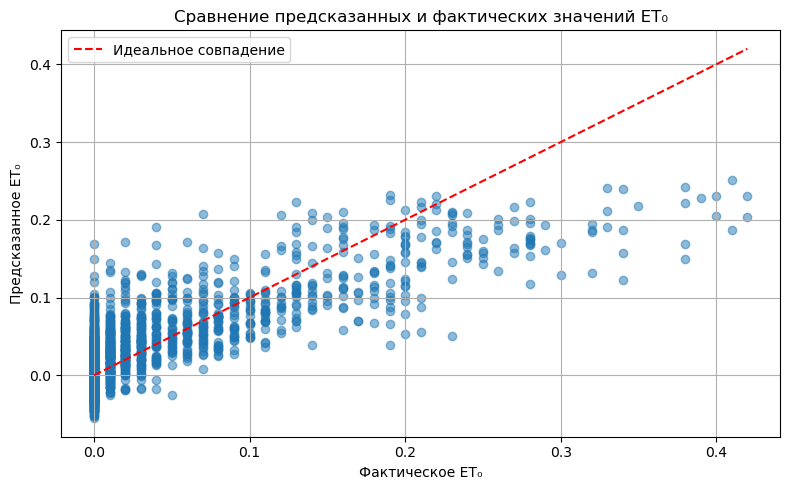

In [198]:
features = [
    "temperature_2m", "relative_humidity_2m", "wind_speed_10m", "precipitation", "rain",
    "snow_depth", "pressure_msl", "wind_direction_10m"]

target = "et0_fao_evapotranspiration"

X = df_hourly[features]
y = df_hourly[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Метрики
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print({
    "LinearRegression": {"RMSE": rmse, "R2": r2},
})

# Коэффициенты линейной регрессии
coefficients = pd.Series(model.coef_, index=features)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальное совпадение')
plt.xlabel("Фактическое ET₀")
plt.ylabel("Предсказанное ET₀")
plt.title("Сравнение предсказанных и фактических значений ET₀")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Обучение моделей RandomForest и XGBoost

In [199]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

# метрики
{
    "RandomForest": {"RMSE": rf_rmse, "R2": rf_r2},
    "XGBoost": {"RMSE": xgb_rmse, "R2": xgb_r2}
}

{'RandomForest': {'RMSE': 0.0009016490981735158, 'R2': 0.8279141862276547},
 'XGBoost': {'RMSE': 0.0010054535738439306, 'R2': 0.8081024016818253}}

Выведем у моделей RandomForest и XGBoost важные признаки

In [200]:
importances_rf = rf_model.feature_importances_
feat_imp_rf_df = pd.DataFrame({
    "feature": features,
    "rf_importance": importances_rf
}).sort_values("rf_importance", ascending=False)
print(feat_imp_rf_df)

                feature  rf_importance
1  relative_humidity_2m       0.460192
0        temperature_2m       0.316493
7    wind_direction_10m       0.058281
5            snow_depth       0.054514
6          pressure_msl       0.052198
2        wind_speed_10m       0.051946
3         precipitation       0.003718
4                  rain       0.002659


In [201]:
importances_xgb = xgb_model.feature_importances_
feat_imp_xgb_df = pd.DataFrame({
    "feature": features,
    "xgb_importance": importances_xgb
}).sort_values("xgb_importance", ascending=False)
print(feat_imp_xgb_df)

                feature  xgb_importance
1  relative_humidity_2m        0.494529
0        temperature_2m        0.213613
5            snow_depth        0.090427
7    wind_direction_10m        0.051196
2        wind_speed_10m        0.047508
6          pressure_msl        0.045945
4                  rain        0.037094
3         precipitation        0.019687


Функция оценки результатов модели на тестовых данных

In [202]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return rmse, r2

lr_rmse, lr_r2 = evaluate_model(model, X_test, y_test)
rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test, y_test)

print("Initial metrics on 2019 test set:")
print("LinearRegression  => RMSE:", lr_rmse,  ", R2:", lr_r2)
print("RandomForest      => RMSE:", rf_rmse,  ", R2:", rf_r2)
print("XGBoost           => RMSE:", xgb_rmse, ", R2:", xgb_r2)

Initial metrics on 2019 test set:
LinearRegression  => RMSE: 0.001939521450939964 , R2: 0.6298292452240736
RandomForest      => RMSE: 0.0009016490981735158 , R2: 0.8279141862276547
XGBoost           => RMSE: 0.0010054535738439306 , R2: 0.8081024016818253


Видим, что лучше всего справляется с задачей модель RandomForest. 

#### Определение примеров для дообучения модели

В качестве стратегии выбора данных для доразметки выберем **Ensemble Disagreement**. Суть данного метода состоит в обучении нескольких моделей. Для каждого неразмеченного объекта смотрим, насколько разнятся предсказания всех моделей. Выбираем объекты, у которых разброс наибольший.

Возьмем те же данные, только за 2020 год

In [203]:
start_date = "2020-01-01"
end_date = "2020-12-31"

params = ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "precipitation", "rain",
         "snow_depth", "et0_fao_evapotranspiration", "pressure_msl", "wind_direction_10m"]
df_hourly_2020 = fetch_hourly_weather_data(params, latitude=latitude, longitude=longitude,
                                      start_date=start_date, end_date=end_date)
df_hourly_2020.head()

,temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation,rain,snow_depth,et0_fao_evapotranspiration,pressure_msl,wind_direction_10m,datetime
0,-4.0,81,11.7,0.1,0.0,0.58,0.0,999.3,279,2020-01-01 00:00:00
1,-3.9,83,7.1,0.2,0.0,0.57,0.0,998.5,294,2020-01-01 01:00:00
2,-3.7,85,7.6,0.2,0.0,0.57,0.0,997.3,289,2020-01-01 02:00:00
3,-2.9,83,3.6,0.5,0.0,0.57,0.0,996.6,270,2020-01-01 03:00:00
4,-4.1,91,1.6,0.3,0.0,0.57,0.0,995.5,63,2020-01-01 04:00:00


In [204]:
df_hourly_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   temperature_2m              8784 non-null   float64       
 1   relative_humidity_2m        8784 non-null   int64         
 2   wind_speed_10m              8784 non-null   float64       
 3   precipitation               8784 non-null   float64       
 4   rain                        8784 non-null   float64       
 5   snow_depth                  8784 non-null   float64       
 6   et0_fao_evapotranspiration  8784 non-null   float64       
 7   pressure_msl                8784 non-null   float64       
 8   wind_direction_10m          8784 non-null   int64         
 9   datetime                    8784 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 686.4 KB


In [205]:
df_hourly_2020 = df_hourly_2020.fillna(method="ffill")

/var/folders/d_/wtjlvc1d5_76_1pt5s0hgj8w0000gn/T/ipykernel_2960/2529617883.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_2020 = df_hourly_2020.fillna(method="ffill")


In [206]:
X_unlabeled = df_hourly_2020[features].copy()
y_unlabeled = df_hourly_2020[target].copy()

In [207]:
import numpy as np

In [208]:
X_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        8784 non-null   float64
 1   relative_humidity_2m  8784 non-null   int64  
 2   wind_speed_10m        8784 non-null   float64
 3   precipitation         8784 non-null   float64
 4   rain                  8784 non-null   float64
 5   snow_depth            8784 non-null   float64
 6   pressure_msl          8784 non-null   float64
 7   wind_direction_10m    8784 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 549.1 KB


Сделаем оценку испаряемости на новых "неразмеченных" данных.

In [209]:
lr_preds  = model.predict(X_unlabeled)
rf_preds  = rf_model.predict(X_unlabeled)
xgb_preds = xgb_model.predict(X_unlabeled)

all_preds = np.vstack([lr_preds, rf_preds, xgb_preds])
std_vals  = np.std(all_preds, axis=0)

Возьмем "топ-100" примеров с наиболее разнящейся оценкой `et0_fao_evapotranspiration`

In [210]:
K = 100

# Сортируем индексы по убыванию std
sorted_indices = np.argsort(-std_vals)
top_k_indices = sorted_indices[:K]

chosen_for_labeling = X_unlabeled.iloc[top_k_indices].copy()
chosen_for_labeling["std_disagreement"] = std_vals[top_k_indices]

In [218]:
chosen_for_labeling.head()

,temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation,rain,snow_depth,pressure_msl,wind_direction_10m,std_disagreement
4051,19.0,49,5.8,0.0,0.0,0.53,1016.4,292,0.076987
3976,18.5,49,13.7,0.0,0.0,0.60,1017.5,256,0.074698
4146,21.9,47,8.3,0.0,0.0,0.43,1018.6,304,0.070834
4722,15.8,58,2.3,0.0,0.0,0.01,1012.2,342,0.069116
4115,16.7,51,8.4,0.0,0.0,0.47,1023.0,100,0.068434


In [219]:
print(f"Минимальное полученное значение 'расхождения' : {chosen_for_labeling["std_disagreement"].min():.3f}")

Минимальное полученное значение 'расхождения' : 0.046


In [220]:
y_chosen = y_unlabeled.iloc[top_k_indices].copy()

Дополним данные для обучения новыми данными

In [221]:
X_train_extended = pd.concat([X_train, chosen_for_labeling], axis=0)[features]
y_train_extended = pd.concat([y_train, y_chosen], axis=0)

In [222]:
X_unlabeled_rest = X_unlabeled.drop(index=top_k_indices)
y_unlabeled_rest = y_unlabeled.drop(index=top_k_indices)

Обучим модели на новых данных

In [223]:
lr_model_updated = LinearRegression()
rf_model_updated = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_updated = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

lr_model_updated.fit(X_train_extended, y_train_extended)
rf_model_updated.fit(X_train_extended, y_train_extended)
xgb_model_updated.fit(X_train_extended, y_train_extended)

lr_rmse_upd, lr_r2_upd = evaluate_model(lr_model_updated, X_test, y_test)
rf_rmse_upd, rf_r2_upd = evaluate_model(rf_model_updated, X_test, y_test)
xgb_rmse_upd, xgb_r2_upd = evaluate_model(xgb_model_updated, X_test, y_test)

In [224]:
print("LinearRegression  => RMSE:", lr_rmse_upd,  ", R2:", lr_r2_upd)
print("RandomForest      => RMSE:", rf_rmse_upd,  ", R2:", rf_r2_upd)
print("XGBoost           => RMSE:", xgb_rmse_upd, ", R2:", xgb_r2_upd)

LinearRegression  => RMSE: 0.0019484576449656774 , R2: 0.6281237123021668
RandomForest      => RMSE: 0.0008938357762557077 , R2: 0.8294054114318
XGBoost           => RMSE: 0.0010077551826512005 , R2: 0.8076631241121068


Визуализируем распределение "расхождений" в предсказаниях модели

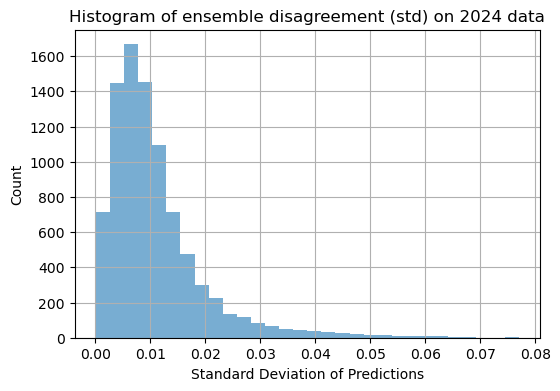

In [178]:
plt.figure(figsize=(6,4))
plt.hist(std_vals, bins=30, alpha=0.6)
plt.title("Histogram of ensemble disagreement (std) on 2024 data")
plt.xlabel("Standard Deviation of Predictions")
plt.ylabel("Count")
plt.grid(True)
plt.show()

Посчитаем разницу в средних значениях между данными для обучения и исходными тренировочными данными

In [179]:
desc_train = X_train[features].describe()

desc_chosen = chosen_for_labeling[features].describe()
# Посчитаем разницу средних значений
mean_diff = desc_chosen.loc["mean"] - desc_train.loc["mean"]
print("\n=== Разница в средних (chosen - train) ===")
print(mean_diff.sort_values())


=== Разница в средних (chosen - train) ===
relative_humidity_2m   -22.319115
wind_speed_10m          -2.166629
precipitation           -0.105296
rain                    -0.035196
snow_depth              -0.002998
wind_direction_10m       5.051878
pressure_msl             7.504202
temperature_2m          14.301917
Name: mean, dtype: float64


Видим, что разница средних в наиболее важных для моделей признаках (влажность + температура) значительна 

Визуализируем распределения исходных тренировочных и новых выбранных данных

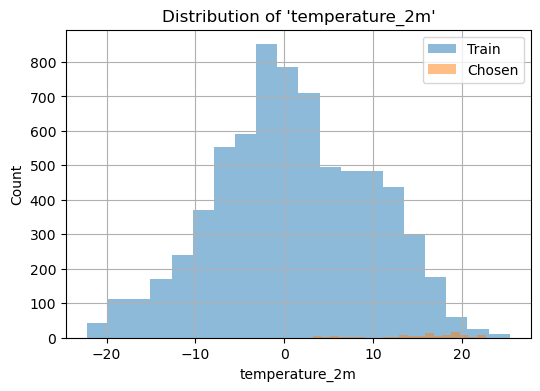

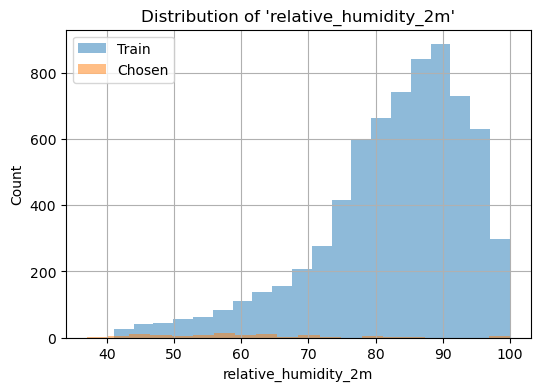

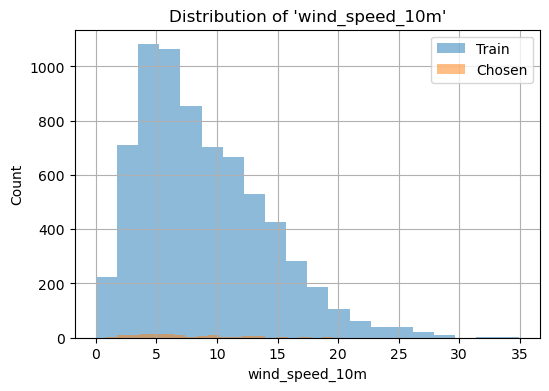

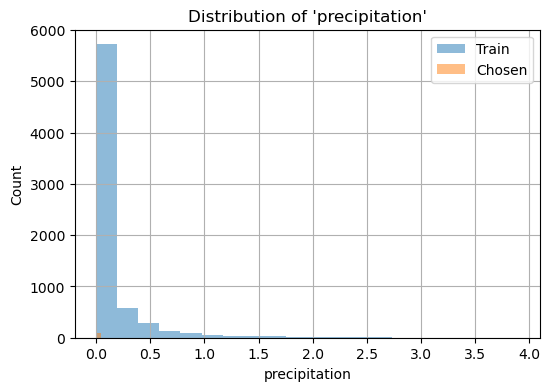

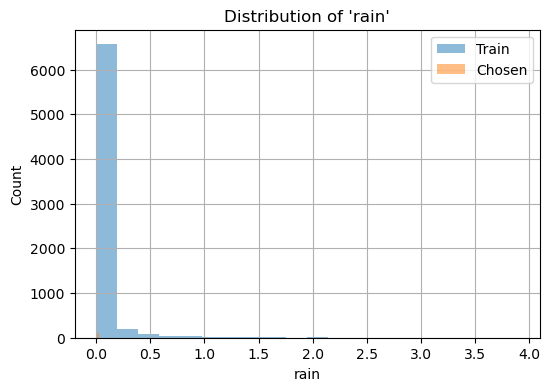

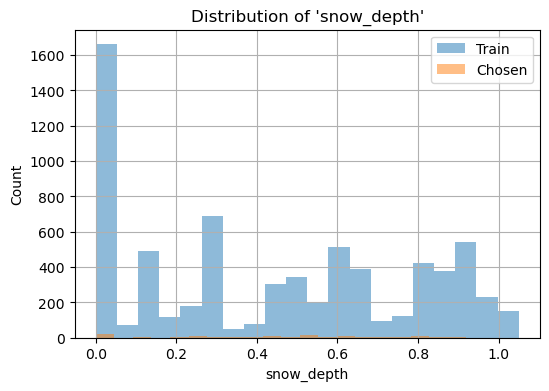

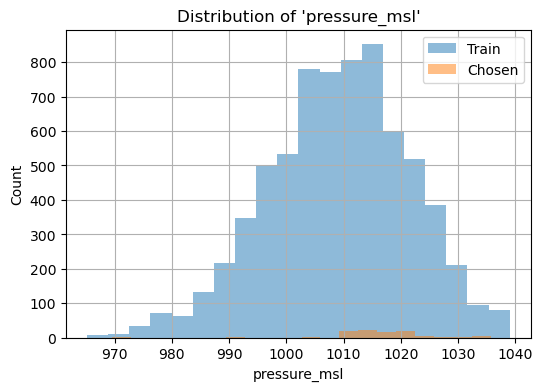

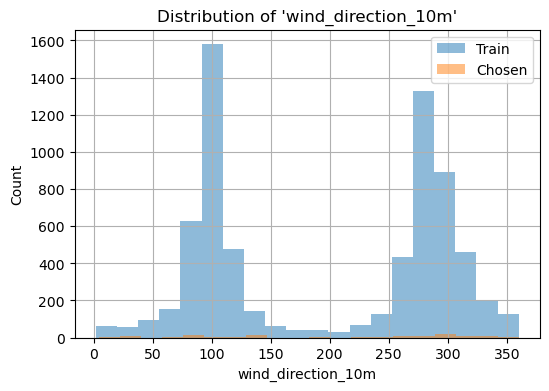

In [180]:
import matplotlib.pyplot as plt

for col in features:
    plt.figure(figsize=(6,4))
    plt.hist(X_train[col], bins=20, alpha=0.5, label='Train')
    plt.hist(chosen_for_labeling[col], bins=20, alpha=0.5, label='Chosen')
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

Исходя из полученных графиков видно, что в качестве данных для дообучения были выбраны более "крайние" значения у температуры и влажности, т.е. тех, которых в исходной выборке было меньше всего.

С помощью метода главных компонент отобразим разницу между исходными и дополнительными данными.

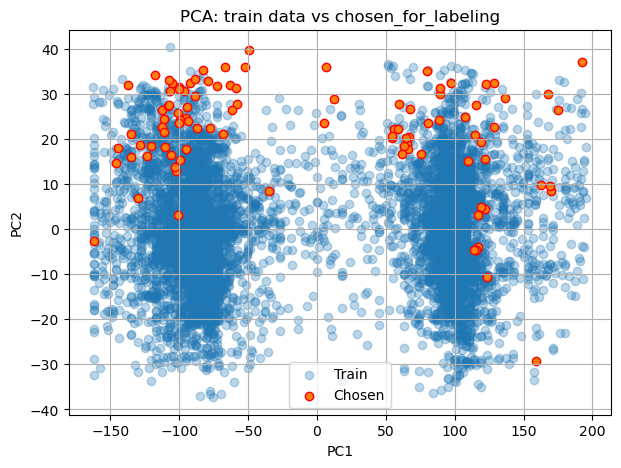

In [181]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train[features])

# Трансформируем train и chosen
train_pca = pca.transform(X_train[features])
chosen_pca = pca.transform(chosen_for_labeling[features])

plt.figure(figsize=(7,5))
plt.scatter(train_pca[:,0], train_pca[:,1], alpha=0.3, label='Train')
plt.scatter(chosen_pca[:,0], chosen_pca[:,1], alpha=1.0, label='Chosen', edgecolors='r')
plt.title("PCA: train data vs chosen_for_labeling")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

Видим, что выбранные объекты действительно более смещены, чем исходные данные. На примере ещё 4 дополнительных лет выберем объекты для дообучения модели и посмотрим, улучшается ли качество моделей на исходных тестовых данных. А также еще раз убедимся в том, что модели выбирают наиболее "полезные" для них данные.

In [186]:
years = ['2021', '2022', '2023', '2024']

В качестве данных, которые будем добавлять для дообучения возьмем не топ-100, а те, в которых "расхождение" превышает 0.05

/var/folders/d_/wtjlvc1d5_76_1pt5s0hgj8w0000gn/T/ipykernel_2960/2939377003.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_year = df_hourly_year.fillna(method="ffill")



After Active Learning (adding K=100 new samples) metrics on 2019 test set:
LinearRegression  => RMSE: 0.001966362212875038 , R2: 0.6247065047153506
RandomForest      => RMSE: 0.0008928771518264841 , R2: 0.8295883713719132
XGBoost           => RMSE: 0.0009832514690656605 , R2: 0.812339823175361

=== Разница в средних (chosen - train) ===
relative_humidity_2m   -26.910351
wind_direction_10m     -15.478796
wind_speed_10m          -1.979966
precipitation           -0.116296
snow_depth              -0.060495
rain                    -0.041196
pressure_msl             9.880225
temperature_2m          14.813569
Name: mean, dtype: float64


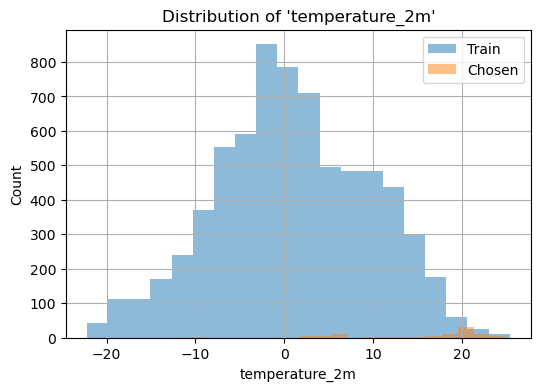

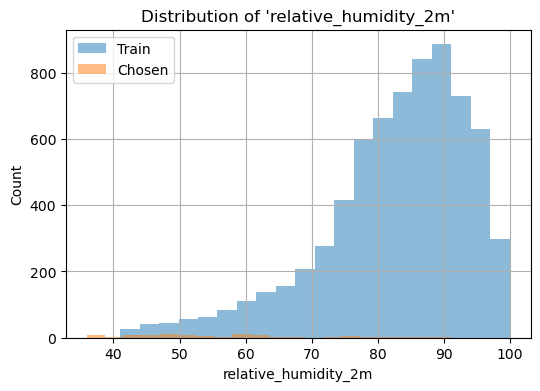

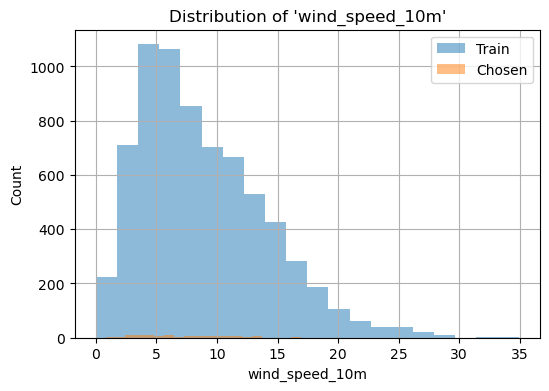

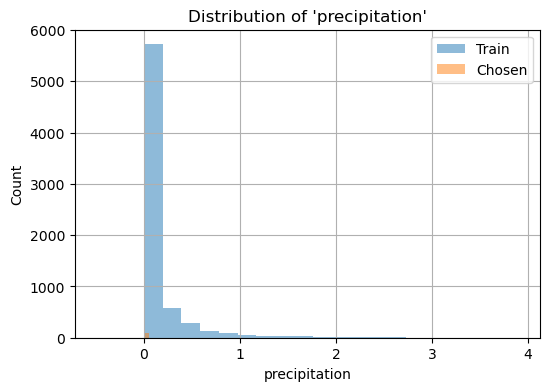

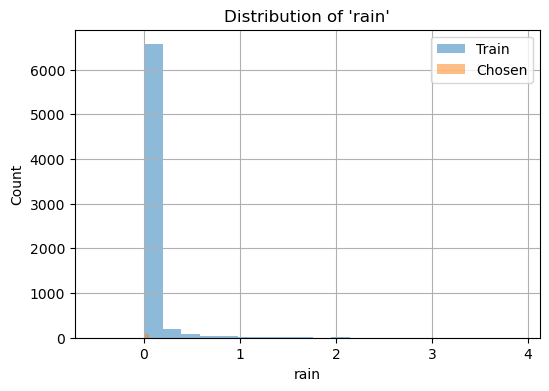

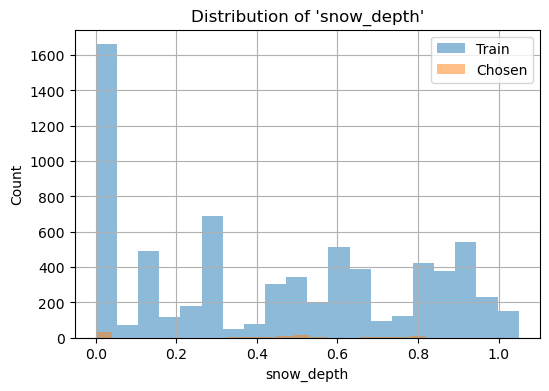

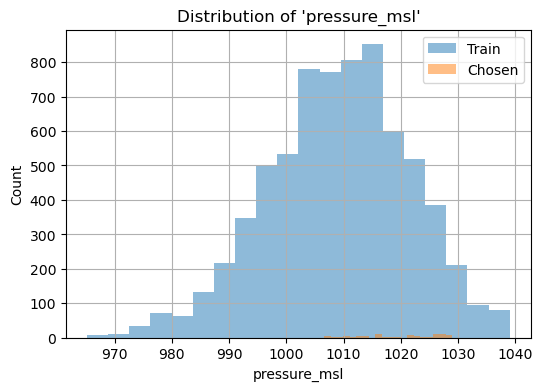

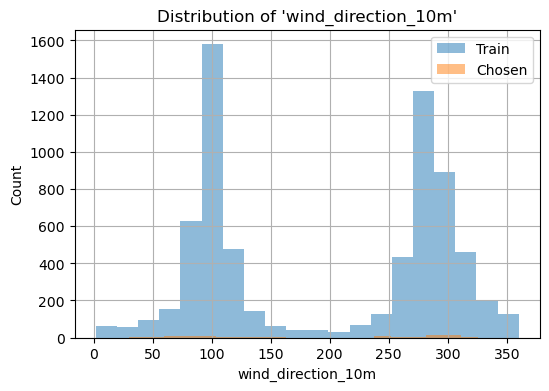

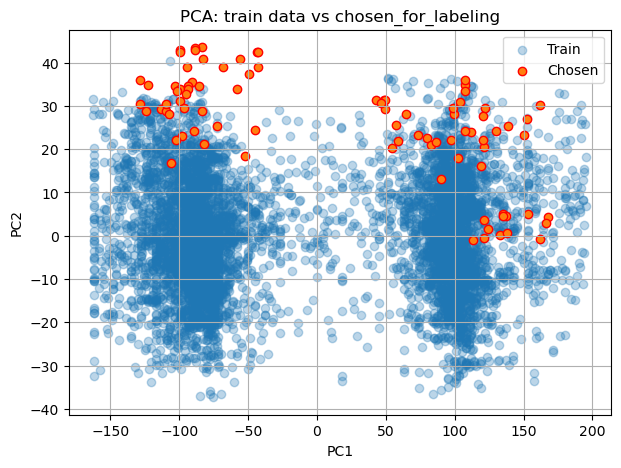

                feature  rf_importance
1  relative_humidity_2m       0.460192
0        temperature_2m       0.316493
7    wind_direction_10m       0.058281
5            snow_depth       0.054514
6          pressure_msl       0.052198
2        wind_speed_10m       0.051946
3         precipitation       0.003718
4                  rain       0.002659


/var/folders/d_/wtjlvc1d5_76_1pt5s0hgj8w0000gn/T/ipykernel_2960/2939377003.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_year = df_hourly_year.fillna(method="ffill")



After Active Learning (adding K=100 new samples) metrics on 2019 test set:
LinearRegression  => RMSE: 0.0019704534013868687 , R2: 0.6239256737848027
RandomForest      => RMSE: 0.0008630867694063927 , R2: 0.8352740668511587
XGBoost           => RMSE: 0.0009384410393385073 , R2: 0.820892196022743

=== Разница в средних (chosen - train) ===
wind_direction_10m     -49.786238
relative_humidity_2m   -22.449840
precipitation           -0.111948
rain                    -0.036848
snow_depth               0.042926
wind_speed_10m           0.672110
pressure_msl             6.790956
temperature_2m          14.947961
Name: mean, dtype: float64


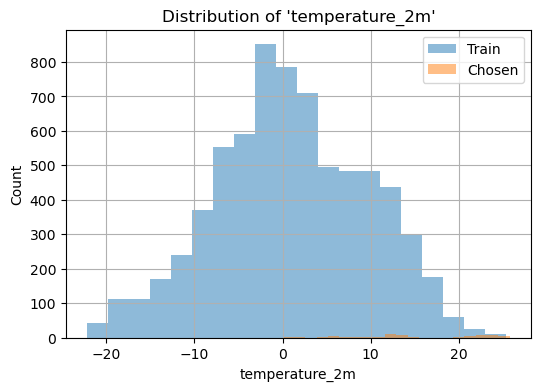

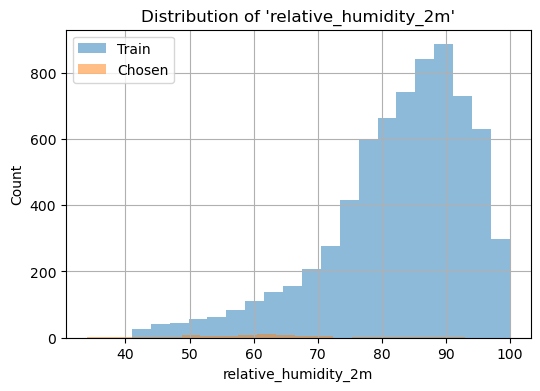

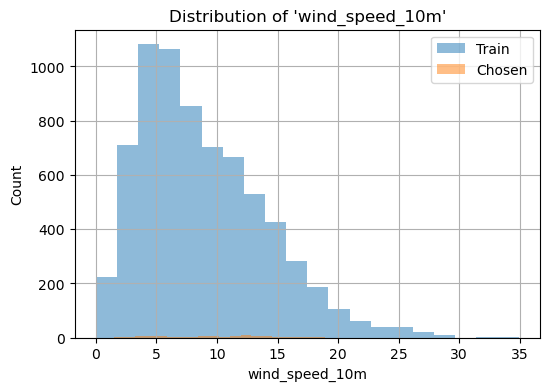

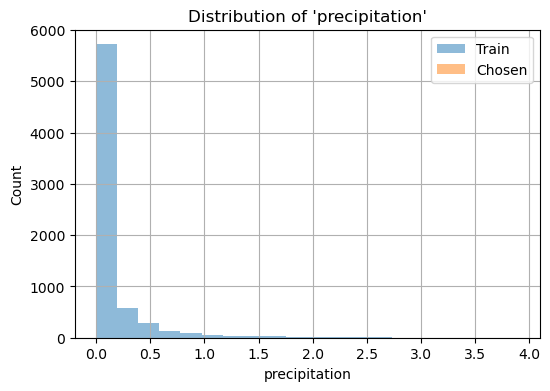

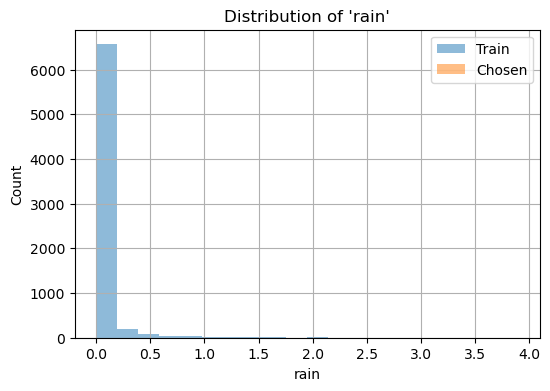

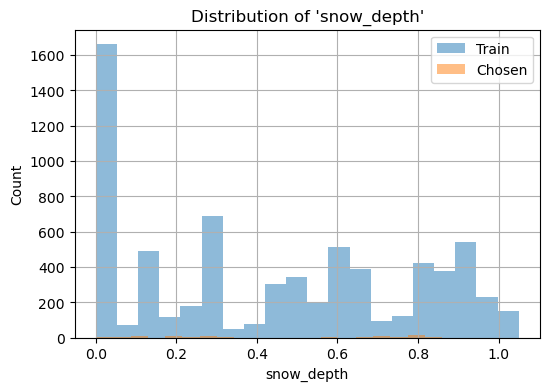

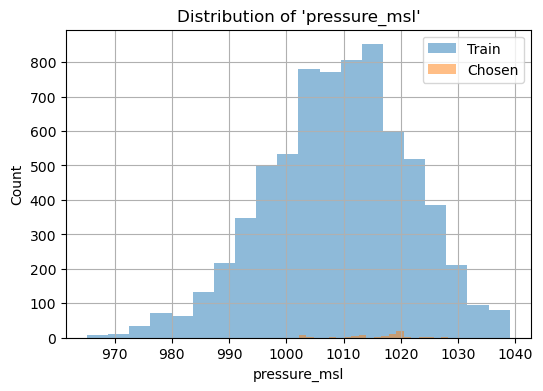

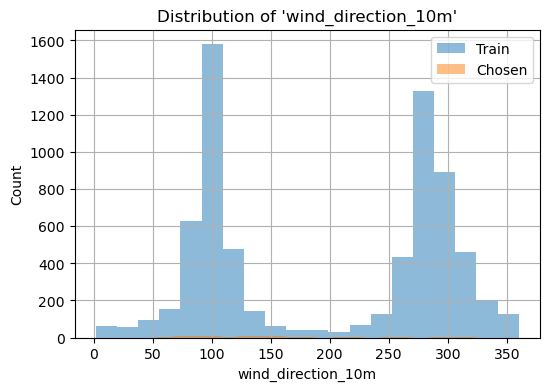

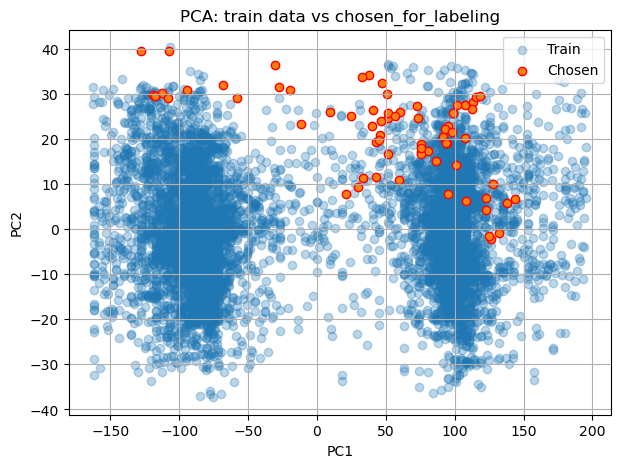

                feature  rf_importance
1  relative_humidity_2m       0.460192
0        temperature_2m       0.316493
7    wind_direction_10m       0.058281
5            snow_depth       0.054514
6          pressure_msl       0.052198
2        wind_speed_10m       0.051946
3         precipitation       0.003718
4                  rain       0.002659


/var/folders/d_/wtjlvc1d5_76_1pt5s0hgj8w0000gn/T/ipykernel_2960/2939377003.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_year = df_hourly_year.fillna(method="ffill")



After Active Learning (adding K=100 new samples) metrics on 2019 test set:
LinearRegression  => RMSE: 0.001980296682790226 , R2: 0.6220470171167949
RandomForest      => RMSE: 0.0008730624828767123 , R2: 0.8333701346296578
XGBoost           => RMSE: 0.0009379851755948234 , R2: 0.8209792006939173

=== Разница в средних (chosen - train) ===
relative_humidity_2m   -27.661827
wind_speed_10m          -2.203866
precipitation           -0.097652
rain                    -0.022552
snow_depth               0.022880
pressure_msl             7.503287
wind_direction_10m      13.371708
temperature_2m          13.823053
Name: mean, dtype: float64


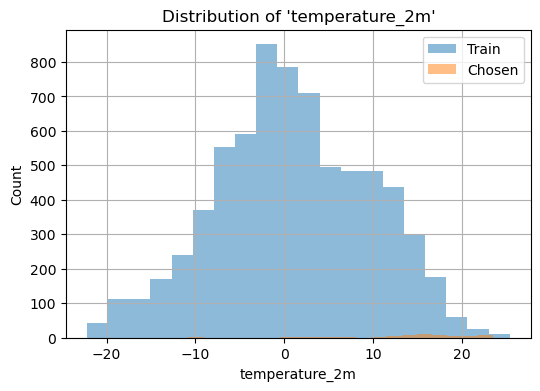

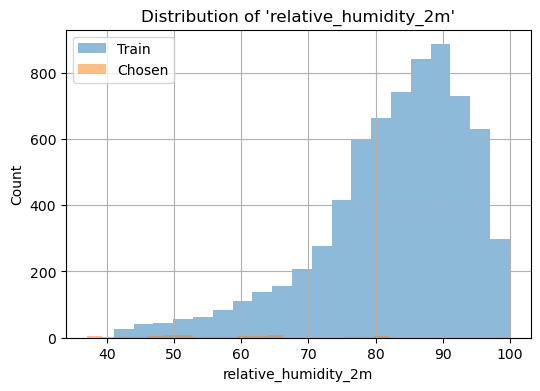

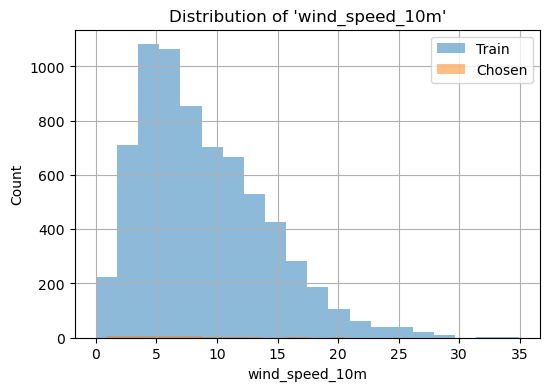

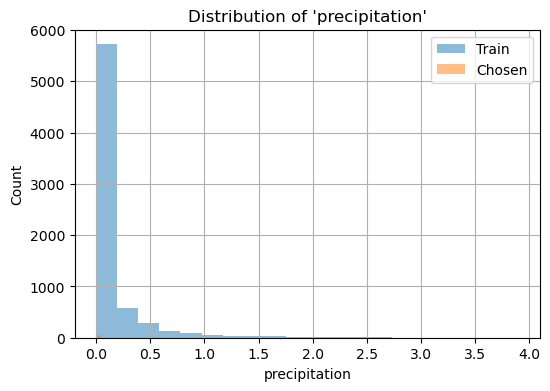

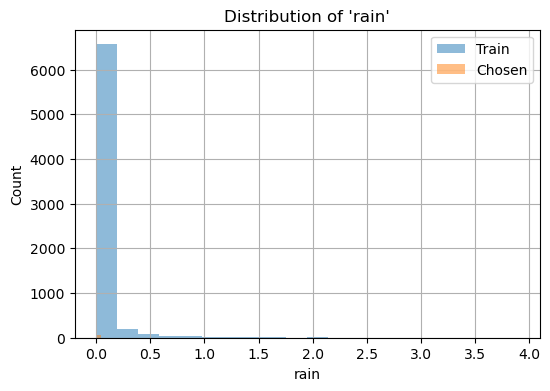

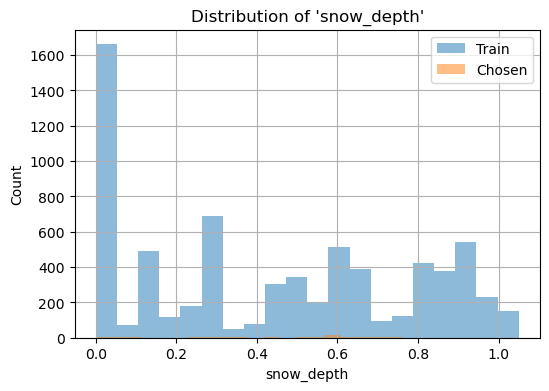

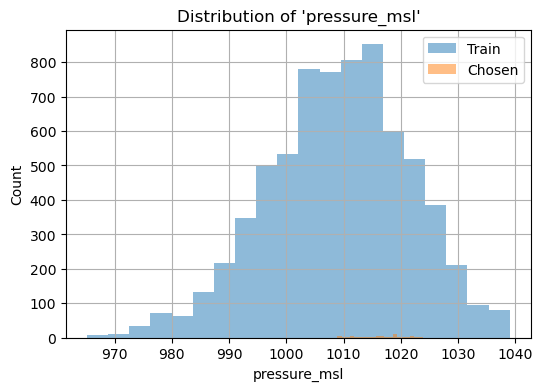

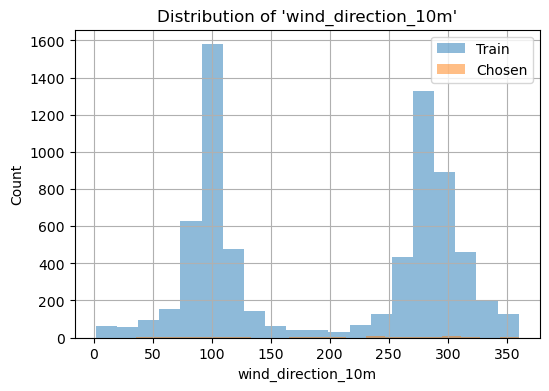

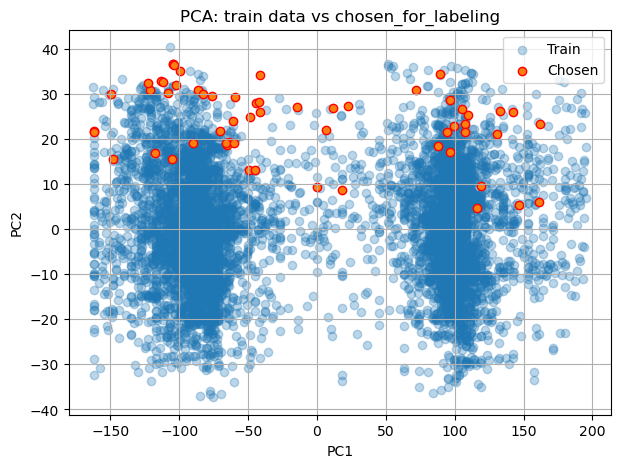

                feature  rf_importance
1  relative_humidity_2m       0.460192
0        temperature_2m       0.316493
7    wind_direction_10m       0.058281
5            snow_depth       0.054514
6          pressure_msl       0.052198
2        wind_speed_10m       0.051946
3         precipitation       0.003718
4                  rain       0.002659


/var/folders/d_/wtjlvc1d5_76_1pt5s0hgj8w0000gn/T/ipykernel_2960/2939377003.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly_year = df_hourly_year.fillna(method="ffill")



After Active Learning (adding K=100 new samples) metrics on 2019 test set:
LinearRegression  => RMSE: 0.001986000440127243 , R2: 0.6209584165460309
RandomForest      => RMSE: 0.0008650263356164384 , R2: 0.8349038875538054
XGBoost           => RMSE: 0.0009649675619380223 , R2: 0.8158294302113701

=== Разница в средних (chosen - train) ===
relative_humidity_2m   -37.709242
wind_speed_10m          -3.593933
snow_depth              -0.213241
precipitation           -0.116296
rain                    -0.041196
temperature_2m           1.081753
pressure_msl             3.765291
wind_direction_10m      14.260359
Name: mean, dtype: float64


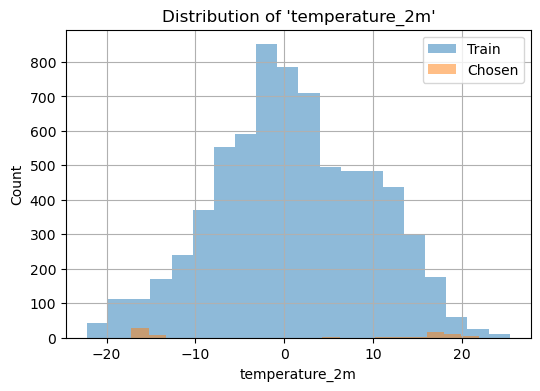

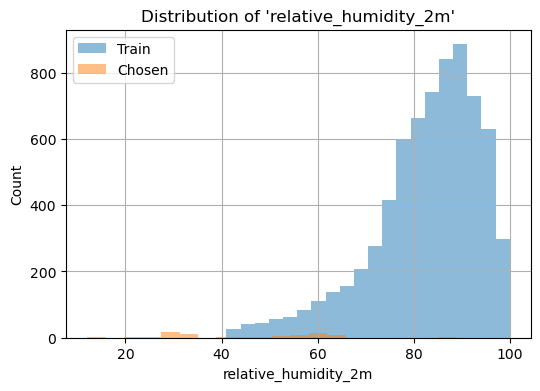

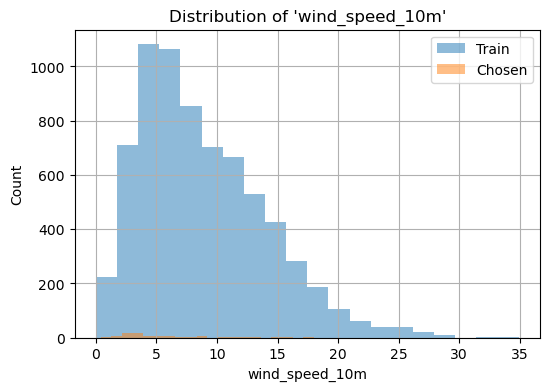

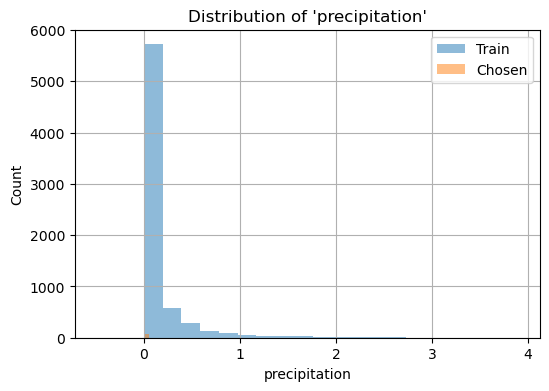

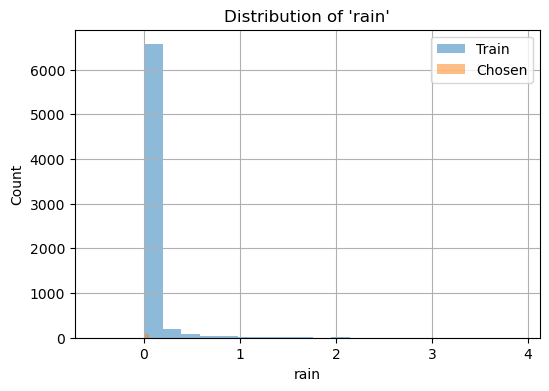

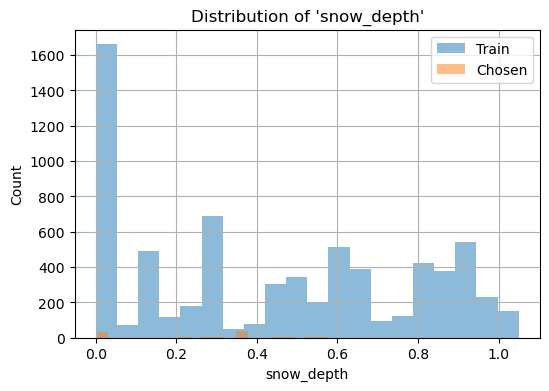

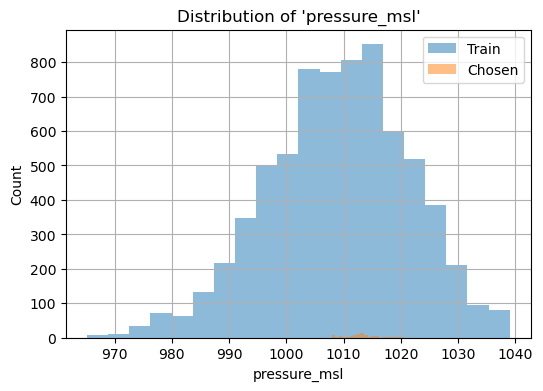

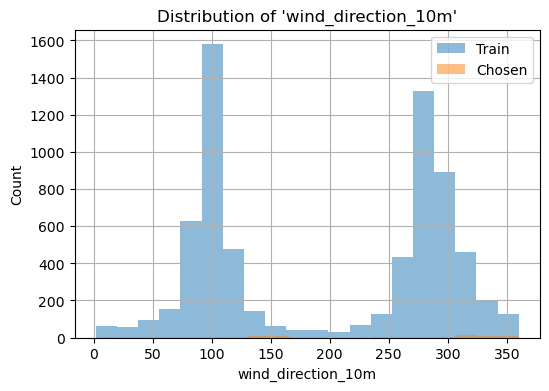

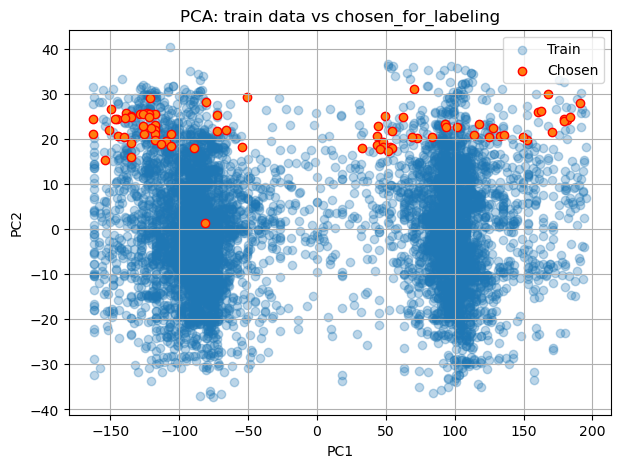

                feature  rf_importance
1  relative_humidity_2m       0.460192
0        temperature_2m       0.316493
7    wind_direction_10m       0.058281
5            snow_depth       0.054514
6          pressure_msl       0.052198
2        wind_speed_10m       0.051946
3         precipitation       0.003718
4                  rain       0.002659


In [187]:
for year in years:
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    params = ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "precipitation", "rain",
             "snow_depth", "et0_fao_evapotranspiration", "pressure_msl", "wind_direction_10m"]
    df_hourly_year = fetch_hourly_weather_data(params, latitude=latitude, longitude=longitude,
                                          start_date=start_date, end_date=end_date)

    df_hourly_year = df_hourly_year.fillna(method="ffill")

    X_unlabeled = df_hourly_year[features].copy()
    y_unlabeled = df_hourly_year[target].copy()

    lr_preds  = model.predict(X_unlabeled)
    rf_preds  = rf_model.predict(X_unlabeled)
    xgb_preds = xgb_model.predict(X_unlabeled)
    
    all_preds = np.vstack([lr_preds, rf_preds, xgb_preds])
    std_vals  = np.std(all_preds, axis=0)

    threshold = 0.05

    mask = std_vals > threshold
    selected_indices = np.where(mask)[0]

    chosen_for_labeling = X_unlabeled[mask].copy()
    chosen_for_labeling["std_disagreement"] = std_vals[mask]
    y_chosen = y_unlabeled[mask].copy()
    
    X_train_extended = pd.concat([X_train_extended, chosen_for_labeling], axis=0)[features]
    y_train_extended = pd.concat([y_train_extended, y_chosen], axis=0)

    lr_model_updated = LinearRegression()
    rf_model_updated = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb_model_updated = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    
    lr_model_updated.fit(X_train_extended, y_train_extended)
    rf_model_updated.fit(X_train_extended, y_train_extended)
    xgb_model_updated.fit(X_train_extended, y_train_extended)
    
    lr_rmse_upd, lr_r2_upd = evaluate_model(lr_model_updated, X_test, y_test)
    rf_rmse_upd, rf_r2_upd = evaluate_model(rf_model_updated, X_test, y_test)
    xgb_rmse_upd, xgb_r2_upd = evaluate_model(xgb_model_updated, X_test, y_test)

    print("\nAfter Active Learning (adding K=%d new samples) metrics on 2019 test set:" % K)
    print("LinearRegression  => RMSE:", lr_rmse_upd,  ", R2:", lr_r2_upd)
    print("RandomForest      => RMSE:", rf_rmse_upd,  ", R2:", rf_r2_upd)
    print("XGBoost           => RMSE:", xgb_rmse_upd, ", R2:", xgb_r2_upd)

    desc_train = X_train[features].describe()
    desc_chosen = chosen_for_labeling[features].describe()
    mean_diff = desc_chosen.loc["mean"] - desc_train.loc["mean"]
    print("\n=== Разница в средних (chosen - train) ===")
    print(mean_diff.sort_values())

    for col in features:
        plt.figure(figsize=(6,4))
        plt.hist(X_train[col], bins=20, alpha=0.5, label='Train')
        plt.hist(chosen_for_labeling[col], bins=20, alpha=0.5, label='Chosen')
        plt.title(f"Distribution of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

    pca = PCA(n_components=2)
    pca.fit(X_train[features])
    
    train_pca = pca.transform(X_train[features])
    chosen_pca = pca.transform(chosen_for_labeling[features])
    
    plt.figure(figsize=(7,5))
    plt.scatter(train_pca[:,0], train_pca[:,1], alpha=0.3, label='Train')
    plt.scatter(chosen_pca[:,0], chosen_pca[:,1], alpha=1.0, label='Chosen', edgecolors='r')
    plt.title("PCA: train data vs chosen_for_labeling")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

    importances_rf = rf_model.feature_importances_
    feat_imp_rf_df = pd.DataFrame({
        "feature": features,
        "rf_importance": importances_rf
    }).sort_values("rf_importance", ascending=False)
    print(feat_imp_rf_df)

Примеры графиков, которые отображают, что модели выбирают наиболее интересные данные со смещением, которых изначально не было в обучающей выборке

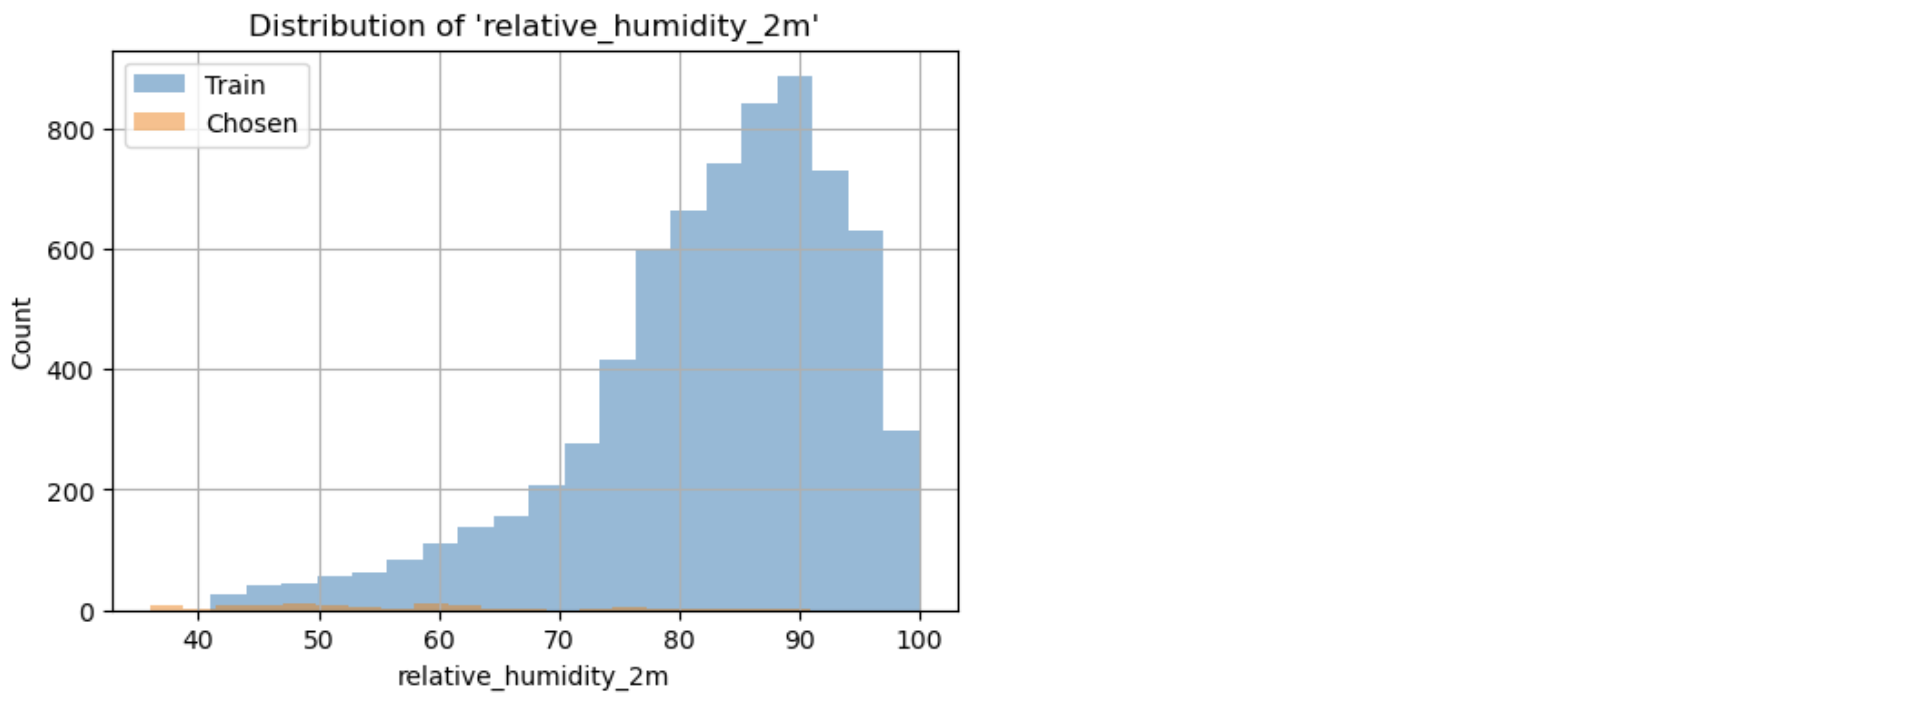
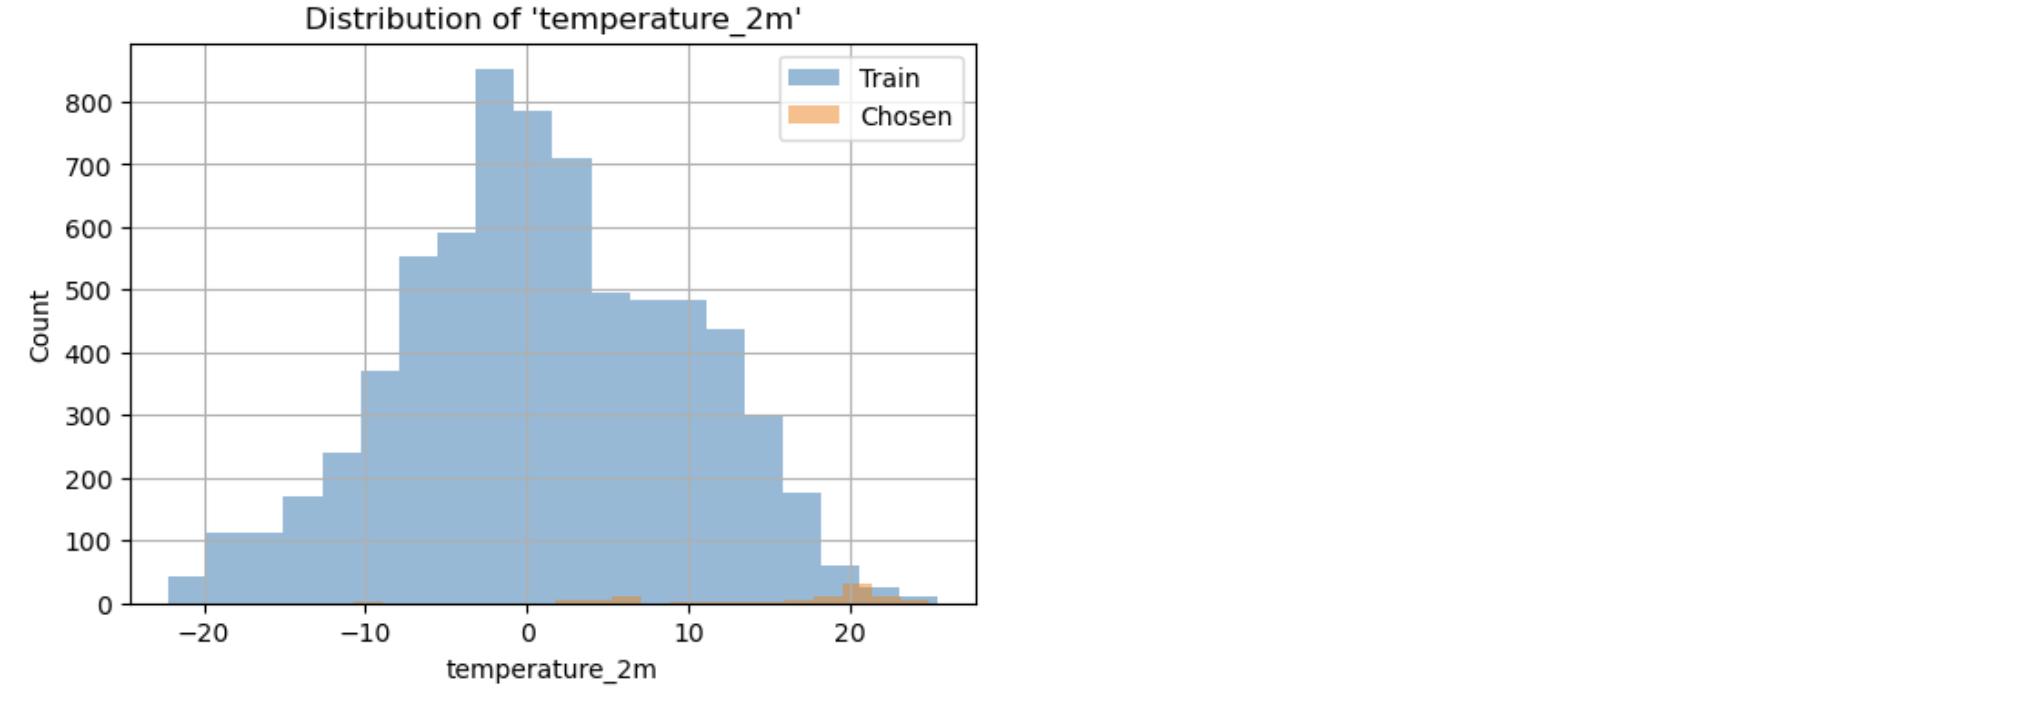

Ниже приведена сводная таблица с метриками (RMSE и R^2) для трёх моделей на тестовой выборке за 2019 год по итерациям.  

| Итерация / Шаг                          | LR $RMSE$        | LR $R^2$         | RF $RMSE$        | RF $R^2$         | XGB $RMSE$       | XGB $R^2$        |
|----------------------------------------|----------------|---------------|----------------|---------------|----------------|----------------|
| **Only 2019**                    | 0.0019 | 0.6298 | 0.0009 | 0.8279 | 0.0010 | 0.8081 |
| **+ 2020**                               | 0.0019 | 0.6281 | 0.0009 | 0.8294 | 0.0010 | 0.8077 |
| **+ 2021** | 0.0020 | 0.6247 | 0.0010 | 0.8296 | 0.0010 | 0.8123 |
| **+ 2022**                               | 0.0020 | 0.6220 | 0.0009 | 0.8334 | 0.0009 | 0.8210 |
| **+ 2023**                               | 0.0020 | 0.6210 | 0.0009 | 0.8349 | 0.0010 | 0.8158 |
| **+ 2024**                               | 0.0020 | 0.6240 | 0.0009 | 0.8353 | 0.0009 | 0.8209 |

Видим, что точность моделей Random Forest и XGBoost с добавлением дополнительных данных начала увеличиваться

#### Вывод

Таким образом, получая каждый час данные с сервера и определяя каждой моделью значение испаряемости, можно сравнивать полученные значения и те, которые превышают пороговое значение, сохранять для дообучения модели. В ходе анализа данных было обнаружено, что модели выбирают наиболее важные для них данные, на которые следует обратить внимание и значений которых не было в исходной обучающей выборке.